<a href="https://colab.research.google.com/github/farshokat/my-project/blob/master/CNN_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ignore warning 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np
import cv2

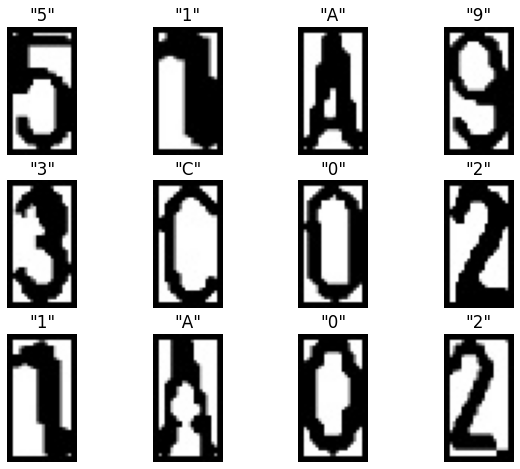

In [2]:
dataset_paths = glob.glob("/content/drive/MyDrive/Data/Data/Train_character/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)

In [3]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)

[INFO] Find 1892 images with 17 classes


In [4]:
# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [5]:
# data augumentation
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

In [6]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

In [7]:
# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 80

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

9412608/9406464 [==============================] - 0s 0us/step


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 40, 40, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 40, 40, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 40, 40, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [9]:
BATCH_SIZE = 16

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="License_character_recognition.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/80
94/94 [==============================] - 56s 539ms/step - loss: 2.9285 - accuracy: 0.1653 - val_loss: 2.2778 - val_accuracy: 0.2401

Epoch 00001: saving model to License_character_recognition.h5
Epoch 2/80
94/94 [==============================] - 49s 521ms/step - loss: 1.6047 - accuracy: 0.5066 - val_loss: 1.6887 - val_accuracy: 0.4538

Epoch 00002: saving model to License_character_recognition.h5
Epoch 3/80
94/94 [==============================] - 49s 522ms/step - loss: 0.9945 - accuracy: 0.6972 - val_loss: 1.4468 - val_accuracy: 0.5145

Epoch 00003: saving model to License_character_recognition.h5
Epoch 4/80
94/94 [==============================] - 49s 521ms/step - loss: 0.6708 - accuracy: 0.8068 - val_loss: 1.2186 - val_accuracy: 0.6359

Epoch 00004: saving model to License_character_recognition.h5
Epoch 5/80
94/94 [==============================] - 49s 519ms/step - loss: 0.4571 - accuracy: 0.8781 - val_loss: 0.9163 - val_accuracy: 0.7309

Epoch 00005: saving model to Lic

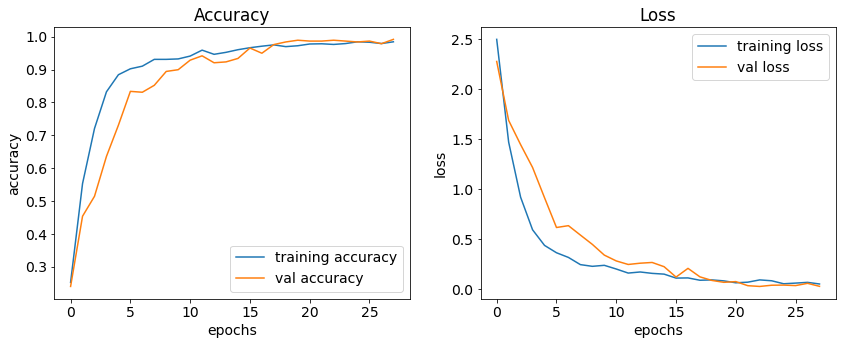

In [10]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [11]:
# save model architectur as json file
model_json = model.to_json()
with open("MobileNets_character_recognition.json", "w") as json_file:
  json_file.write(model_json)

In [12]:
# Load model architecture, weight and labels
json_file = open('/content/MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/content/License_character_recognition.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('/content/license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [13]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

In [14]:
def find_contours(dimensions, img) :


    # Find all contours in the image
    cntrs,hierarchy= cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:20]

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)

    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
    
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [15]:
def segment_characters(image) :

    #Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    #*plt.imshow(img_lp)
    #*plt.show()
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_gray_lp)
    #*plt.show()
    _, img_binary_lp = cv2.threshold(img_gray_lp, 255, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #*plt.imshow(img_binary_lp)
    #*plt.show()
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    #*plt.imshow(img_binary_lp)
    #*plt.show()
    img_binary_lp1 = cv2.dilate(img_binary_lp,(3,3))
    #plt.show(img_binary_lp1)
    #plt.show()
    #plt.imshow(img_binary_lp)
    #img_binary_lp = cv2.resize(image, (333, 75))

    LP_WIDTH = img_binary_lp1.shape[0]
    LP_HEIGHT = img_binary_lp1.shape[1]

    # Make borders white
    img_binary_lp1[0:3,:] = 0
    img_binary_lp1[:,0:3] = 0
    img_binary_lp1[72:75,:] = 0
    img_binary_lp1[:,330:333] = 0

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/9,
                       LP_WIDTH/1,
                       LP_HEIGHT/9,
                       LP_HEIGHT/1]
    plt.imshow(img_binary_lp1, cmap='gray')
    plt.show()
    #cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp1)

    return char_list

   #def bwareaopen(image, areaPixels):
        #image = img_binary_lp1.copy()
        
        #for idx in np.arange(len(contours)):
            #area = cv2.contourArea(contour[idx])
            #if (area >= 0 and area <= areaPixels):
                #cv2.drawContour(image, contour, idx, (0,0,0), -1)
        #return img_binary_lp1

In [16]:
cv_img = []
for img in glob.glob("/content/drive/MyDrive/Data/Data/image test/*.jpg"):
    name_img=img.split("/")[-1] 
    n= cv2.imread(img,1)
    cv_img.append(n)

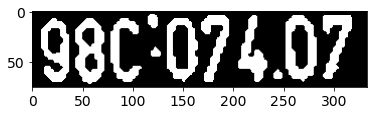

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


8
38C07407
1


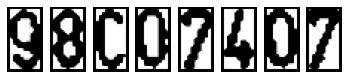

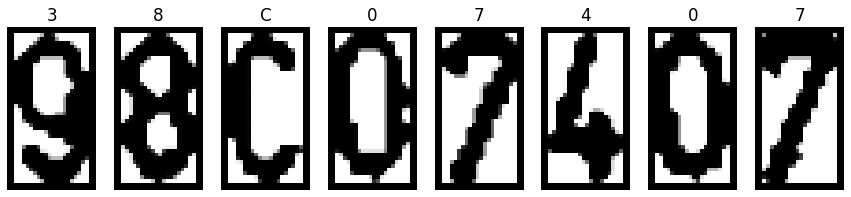

In [18]:
image = cv_img[53].copy()
#plt.imshow(image)

char = segment_characters(image)

for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
#print(len(char))

listchar = []
for i in range(len(char)):
    if np.sum(char[i] == 0) > np.sum(char[i] == 255):
        listchar.append(char[i])
for i in range(len(listchar)):
    plt.subplot(1, len(listchar), i+1)
    plt.imshow(listchar[i], cmap='gray')
    plt.axis('off')
#print(len(listchar))

listfinal = []
if len(char) == 8:
    listfinal = char.copy()
    for i in range(len(listfinal)):
        plt.subplot(1, len(listfinal), i+1)
        plt.imshow(listfinal[i], cmap='gray')
        plt.axis('off')
if len(char) != 8 and len(listchar) == 8:
    listfinal = listchar.copy()
for i in range(len(listfinal)):
    plt.subplot(1, len(listfinal), i+1)
    plt.imshow(listfinal[i], cmap='gray')
    plt.axis('off')
print(len(listfinal))

fig = plt.figure(figsize=(15,3))
cols = len(listfinal)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(listfinal):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)

results = []
results.append(final_string)
print(len(results))

#print(results)

In [218]:
.from pathlib import Path

In [256]:
!unzip -qq /content/drive/MyDrive/process_image_test.zip

replace process_image_test/00004654_92C11106.jpg.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [232]:
path_test = Path("/content/drive/MyDrive/Data/Data/image test/")


# Get list of all the images
images_test = sorted(list(map(str, list(path_test.glob("*.jpg")))))
labels_test = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images_test]

'''labels_test = []
for i in labels_test1:
  labels_test.append(i[9:17])

print(labels_test)'''

'labels_test = []\nfor i in labels_test1:\n  labels_test.append(i[9:17])\n\nprint(labels_test)'

In [233]:
len(labels_test)

70

In [225]:
print(labels_test)

['92A03504', '92A04067', '92A05660', '92A05905', '92A06021', '92A06189', '92A06437', '92A07934', '92A08173', '92A09176', '92A09375', '92A09408', '92A09491', '92A09648', '92A09721', '92A09721A', '92A09882', '92A10486', '92A10486A', '92A10631', '92A10801', '92B00400', '92B00897', '92B01201', '92C01099', '92C02103', '92C02329', '92C02464', '92C03930', '92C04019', '92C04019C', '92C04510', '92C04749', '92C04963', '92C05045', '92C05262', '92C05437', '92C05979', '92C06067', '92C06272', '92C06616', '92C06827', '92C07464', '92C07473', '92C08343', '92C08530', '92C08723', '92C08723C', '92C08786', '92C09229', '92C09532', '92C09618', '92C09646', '92C10160', '92C10300', '92C10361', '92C10612', '92C10720', '92C11106', '92C11235', '92C11258', '92C11285', '92C11460', '92C11783', '92C12191', '92C12684', '98C07170', '98C07407', '98C09800', '98C10268']


In [234]:
labelsfinal = []
for i in labels_test:
  labelsfinal.append(i[0:8])

print(labelsfinal)

['92A03504', '92A04067', '92A05660', '92A05905', '92A06021', '92A06189', '92A06437', '92A07934', '92A08173', '92A09176', '92A09375', '92A09408', '92A09491', '92A09648', '92A09721', '92A09721', '92A09882', '92A10486', '92A10486', '92A10631', '92A10801', '92B00400', '92B00897', '92B01201', '92C01099', '92C02103', '92C02329', '92C02464', '92C03930', '92C04019', '92C04019', '92C04510', '92C04749', '92C04963', '92C05045', '92C05262', '92C05437', '92C05979', '92C06067', '92C06272', '92C06616', '92C06827', '92C07464', '92C07473', '92C08343', '92C08530', '92C08723', '92C08723', '92C08786', '92C09229', '92C09532', '92C09618', '92C09646', '92C10160', '92C10300', '92C10361', '92C10612', '92C10720', '92C11106', '92C11235', '92C11258', '92C11285', '92C11460', '92C11783', '92C12191', '92C12684', '98C07170', '98C07407', '98C09800', '98C10268']


In [235]:
len(set(labelsfinal) & set(results))

45